In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D,
    Concatenate, Add, GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def inception_module(input_tensor, filters=32):
    conv1 = Conv1D(filters, 1, padding='same', activation='relu')(input_tensor)
    conv3 = Conv1D(filters, 3, padding='same', activation='relu')(input_tensor)
    conv5 = Conv1D(filters, 5, padding='same', activation='relu')(input_tensor)
    conv7 = Conv1D(filters, 7, padding='same', activation='relu')(input_tensor)
    output = Concatenate(axis=-1)([conv1, conv3, conv5, conv7])
    return output

In [9]:
def resnet_block(input_tensor, filters=64, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = Conv1D(filters, kernel_size, padding='same', activation='linear')(x)
    x = Add()([x, input_tensor])  # 스킵 연결
    x = Dense(filters, activation='relu')(x)
    return x

In [11]:
inputs = Input(shape=(n_timesteps, n_features))
x = inception_module(inputs, filters=32)
x = MaxPooling1D(pool_size=2)(x)
x = resnet_block(x, filters=128)  # Changed filters to 128 to match the output of inception_module after MaxPooling1D
x = resnet_block(x, filters=128) # Kept filters at 128 for consistency within the ResNet blocks
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

inception_resnet_model = Model(inputs, outputs)
inception_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
inception_resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 32)   │        320 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 32)   │        896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      1,472 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      2,048 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128)  │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 64, 128)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 64, 128)   │     49,280 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 64, 128)   │     49,280 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 128)   │          0 │ conv1d_11[0][0],  │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 128)   │     16,512 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 64, 128)   │     49,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 64, 128)   │     49,280 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 128)   │          0 │ conv1d_13[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │     16,512 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │      3,078 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 304,006 (1.16 MB)

 Trainable params: 304,006 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_history = inception_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.6682 - loss: 0.7837 - val_accuracy: 0.9219 - val_loss: 0.2239
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9337 - loss: 0.1994 - val_accuracy: 0.9304 - val_loss: 0.1476
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9448 - loss: 0.1390 - val_accuracy: 0.9626 - val_loss: 0.1131
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9452 - loss: 0.1438 - val_accuracy: 0.8981 - val_loss: 0.3052
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9216 - loss: 0.2051 - val_accuracy: 0.9474 - val_loss: 0.1128
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9512 - loss: 0.1135 - val_accuracy: 0.9559 - val_loss: 0.0965
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9523 - loss: 0.1106 - val_accuracy: 0.9372 - val_loss: 0.1315
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9563 - loss: 0

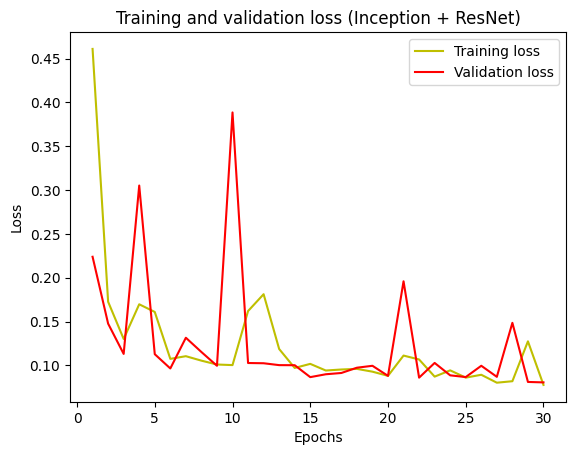

In [13]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (Inception + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

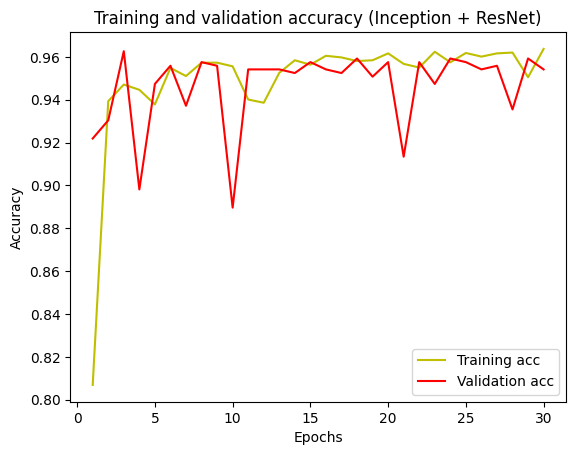

In [14]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (Inception + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
[[476   9  11   0   0   0]
 [  0 467   4   0   0   0]
 [  0   0 420   0   0   0]
 [  0   2   0 416  68   5]
 [  0   0   0  91 441   0]
 [  0  24   0   0   1 512]]
0.9270444519850696
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.93      0.99      0.96       471
           2       0.97      1.00      0.98       420
           3       0.82      0.85      0.83       491
           4       0.86      0.83      0.85       532
           5       0.99      0.95      0.97       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

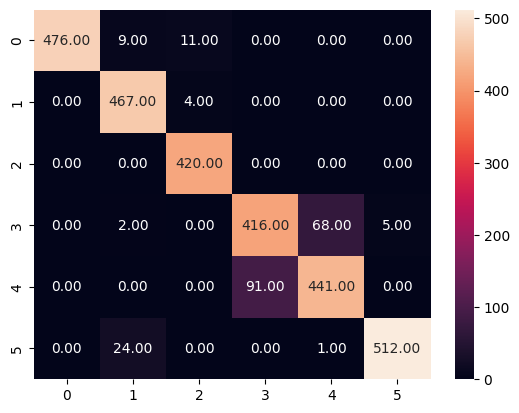

In [15]:
pred = inception_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')